In [ ]:
%%bash
source activate python2
pip install --user FlowCytometryTools

In [1]:
from FlowCytometryTools import FCMeasurement
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fcs2df(dfSource):
    cols = [u'FSC-A', u'SSC-A', u'FL1-A', u'FL2-A', u'FL3-A', u'FL4-A',
           u'FSC-H', u'SSC-H', u'FL1-H', u'FL2-H', u'FL3-H', u'FL4-H',
           u'Width', u'Time', u'Lab',u'Strain', u'bioReplicate',u'techReplicate']

    dfNew = pd.DataFrame(columns=cols)
    counts = []
    for i in range(len(dfSource)):
        data = dfSource.loc[i]
        fileNm = data['filePath']
        sample = FCMeasurement(ID=fileNm,datafile=fileNm)
        dfT = pd.DataFrame(data=sample.data)
        dfT['Lab'] = data['lab']
        dfT['bioReplicate'] = data['bioReplicate']
        dfT['techReplicate'] = data['techReplicate']
        dfT['Strain'] = data['strainID']
        dfNew = pd.concat([dfNew,dfT])
        counts.append(len(dfT))

    dfSource['numCounts'] = counts
    return dfSource, dfNew

In [3]:
def getFiles(folderDir, removeExtras = 0):
    baseDir = '/home/jupyter/sd2e-community/ingest/Q0/sd2.transcriptic.upload/YeastGates/'
    fileList = sorted(os.listdir(baseDir+folderDir))
    fileList = [x for x in fileList if x[-3:] == 'fcs']
    fileList = [x for x in fileList if 'Group' not in x]
    if removeExtras:
        fileList = [x for x in fileList if len(x) < 8]
    filePaths = [baseDir+folderDir+f for f in fileList]
    return fileList, filePaths

def getFiles(folderDir, removeExtras = 0):
    fileList = sorted(os.listdir(baseDir+folderDir))
    if removeExtras:
        fileList = [x for x in fileList if len(x) < 8]
    filePaths = [baseDir+folderDir+f for f in fileList]
    return fileList, filePaths

In [4]:
def flowViz(df,date):

    for n in [1,2,3,4]:
        channel = 'FL{}'.format(n)
        sns.set_style('ticks')
        fig, ax = plt.subplots(5,2,figsize=(8,15))
        sns.set_palette('cubehelix',6)
        cond = ['WT','XOR_00','XOR_01','XOR_10','XOR_11']
        for c, axR in zip(cond,range(5)):
            dfT = df[df['Strain'] == c]
            ax[axR,0].annotate(c,(0.05,0.9),xycoords='axes fraction')
            for samp in sorted(set(dfT.bioReplicate)):
                data = dfT[dfT['bioReplicate'] == samp]['{}-H'.format(channel)]
                sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,0])
                ax[axR,0].set_xlim([1,5])
                data = dfT[dfT['bioReplicate'] == samp]['{}-A'.format(channel)]
                sns.distplot(np.log10(data[data > 0]),hist=False,ax = ax[axR,1])
                ax[axR,1].set_xlim([1,5])
        sns.despine()
        ax[0,0].legend(['R{}'.format(i+1) for i in range(6)],loc='upper right')
        fig.savefig(outputDir+'Biofab_flow_{}_{}.pdf'.format(channel,date))

### UW Biofab 20170811

In [5]:
folderDir = '20170811_103245_Static_96W_6-reps/readings/'
flowDate = '20170811'
originatorLab = 'UWBiofab'
reps = 6

fileList, filePaths = getFiles(folderDir, removeExtras = 0)

date = [flowDate for i in range(5*reps)]
lab = [originatorLab for i in range (5*reps)]
well = ['{}{:02d}'.format(lett,num) 
        for lett in 'ABCDE' for num in range(7,12+1)]
strainList = ['WT','XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
bioRep = [r+1 for rep in range(5) for r in range(reps)]
techRep = [1 for i in range(5*reps)]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfA = pd.DataFrame(frame).transpose()
dfA.columns = colNames

Convert fcs files to dataframe

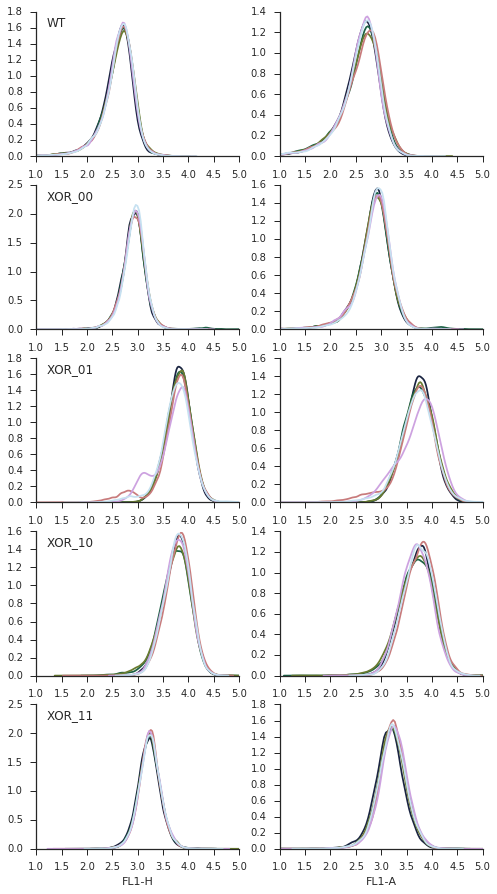

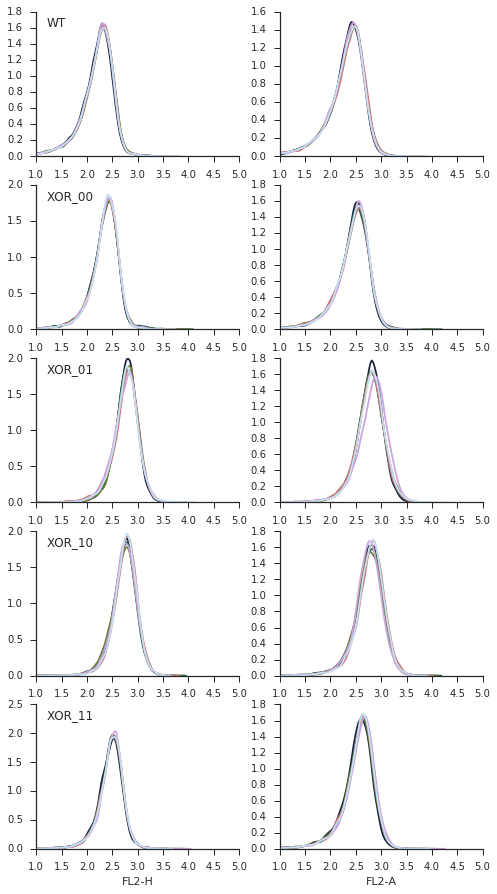

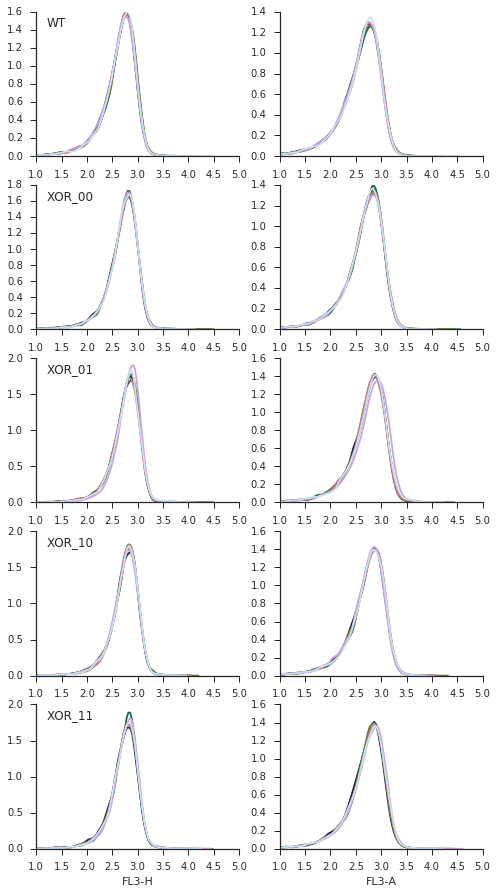

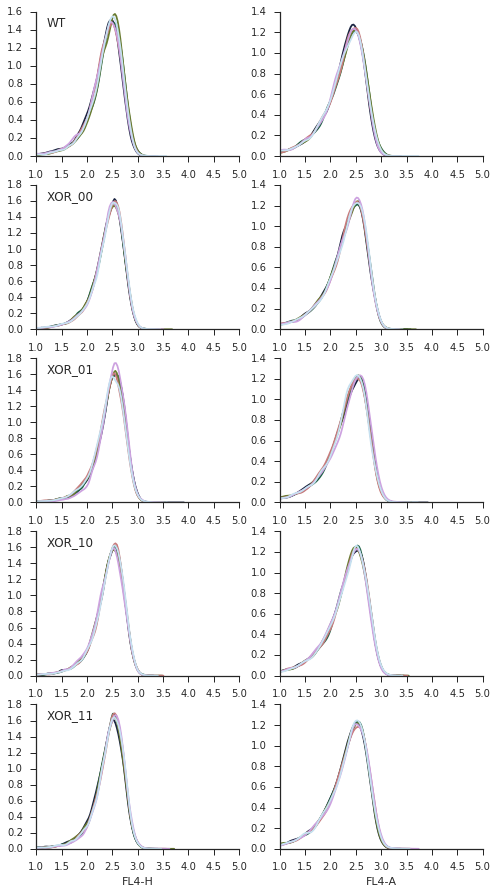

In [17]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/'
dfA, dfB = fcs2df(dfA)

dfA.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfB.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

In [ ]:
flowViz(dfB,flowDate)

### Forward / side scatter visualization

In [10]:
test = dfB[dfB['Strain'] == 'WT']
test = test[test['bioReplicate'] == 1]
test = test[test['FSC-A'] < 3e6]
test = test[test['FSC-H'] < 3.5e6]

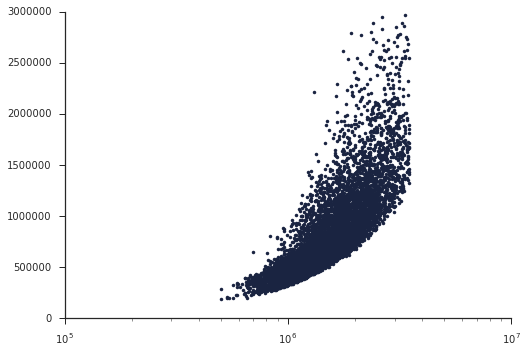

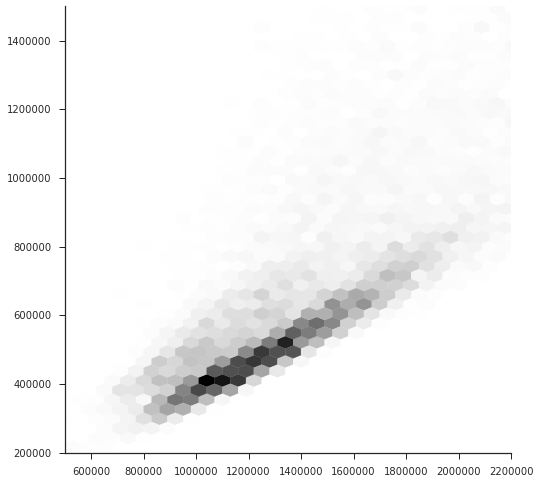

In [11]:
plt.plot(test['FSC-H'],test['FSC-A'],'.')
plt.xscale('log')
#plt.yscale('log')
sns.despine()

#sns.kdeplot(test[['FSC-H','FSC-A']])
fig,ax = plt.subplots(1,1,figsize=(8,8))
#fig = sns.jointplot("FSC-H", "FSC-A", data=test, size = 8, ratio=10, kind="hex")
ax.hexbin(test['FSC-H'],test['FSC-A'],gridsize=(50,50))
ax.set_xlim([5e5,2.2e6])
ax.set_ylim([2e5,1.5e6])
sns.despine()

### UW Biofab 20170929

In [12]:
folderDir = '20170929_114545/readings/'
flowDate = '20170929'
originatorLab = 'UWBiofab'
fileList, filePaths = getFiles(folderDir, removeExtras = 1)
reps = 3

date = [flowDate for i in range(5*reps)]
lab = [originatorLab for i in range (5*reps)]
wellA = ['A{:02d}'.format(num) for num in range(1,12+1)]
wellB = ['B01','B02','B03']
well = [w for wellList in [wellA, wellB] for w in wellList]
strainList = ['WT','XOR_00','XOR_01','XOR_10','XOR_11']
strainID = [strain for strain in strainList for rep in range(reps)]
bioRep = [r+1 for rep in range(5) for r in range(reps)]
techRep = [1 for i in range(5*reps)]
colNames = ['date','lab','well','strainID','bioReplicate',
            'techReplicate','filePath']
frame = [date, lab, well, strainID, bioRep, techRep, filePaths]
dfC = pd.DataFrame(frame).transpose()
dfC.columns = colNames

Convert fcs files to dataframe

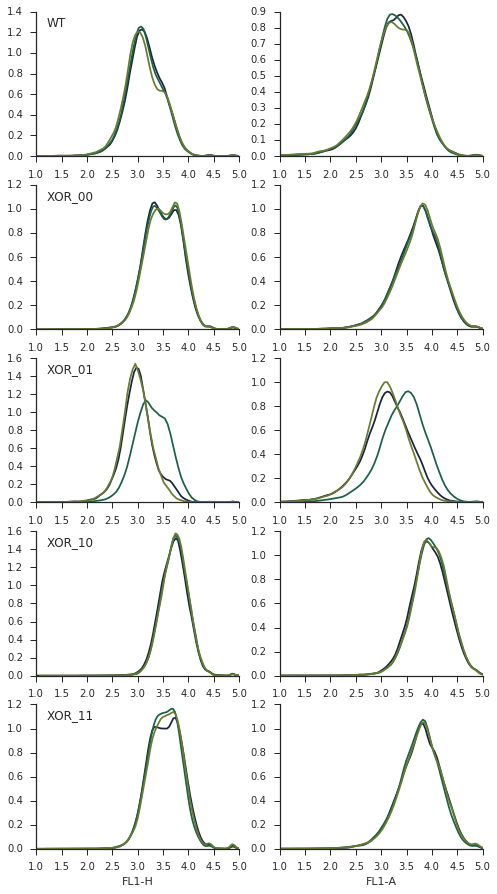

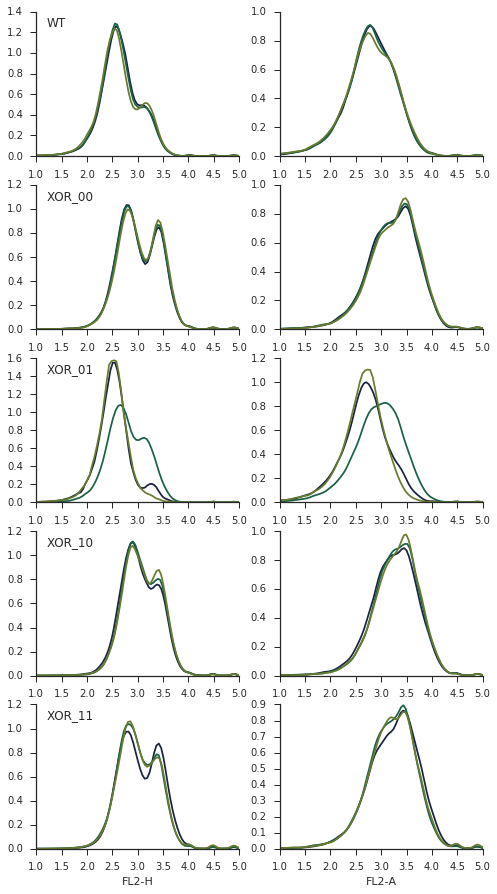

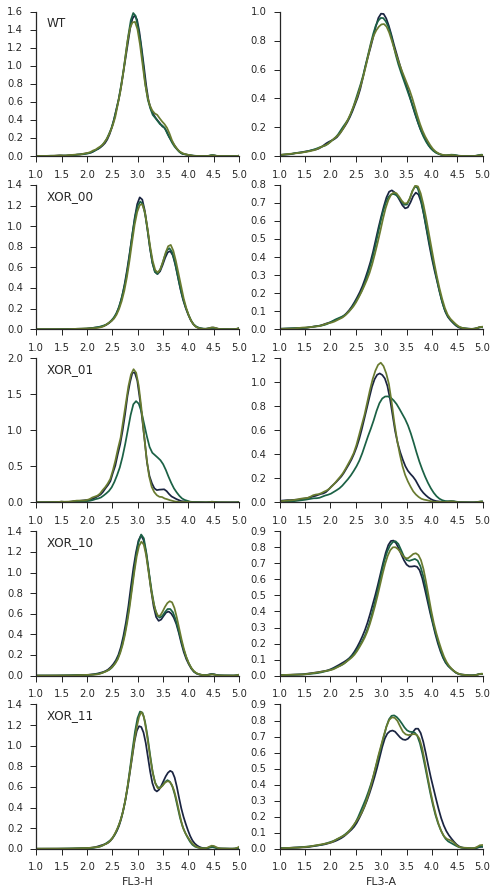

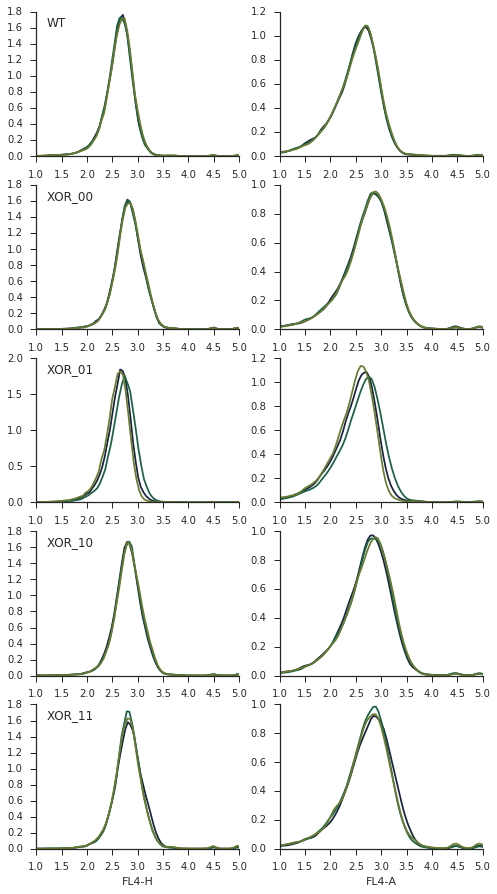

In [18]:
outputDir = '/home/jupyter/sd2e-community/shared-q0-hackathon/yeast-gates/flowDataFrames/'

dfC, dfD = fcs2df(dfC)

dfC.to_csv(outputDir+'{}_{}_sampleTable.csv'.format(originatorLab,flowDate))
dfD.to_csv(outputDir+'{}_{}_flowDataFrame.csv'.format(originatorLab,flowDate))

In [ ]:
flowViz(dfD,flowDate)